In [1]:
import numpy as np
import sympy as sp
import os
import matplotlib.pyplot as plt
from sympy.physics.quantum import TensorProduct as ts
from sympy.physics.quantum.dagger import Dagger
from sympy.physics.matrices import msigma
from sympy.plotting import plot
from sympy import lambdify

import pickle
from qutip import *

\begin{align}
H_{\text{ini}}&=\hbar\Omega \left[ \sigma_{x}\sigma_{x} + \sigma_{y}\sigma_{y}\right] \mathbb{1} ,\\
H_{\text{inter}}&=\hbar\Omega \mathbb{1}\left[ \sigma_{x}\sigma_{x}+ \sigma_{y}\sigma_{y}\right] ,\\
H_{\text{fin}}&=\hbar\Omega \left[ \sigma_{z}\mathbb{1}\sigma_{z} + \mathbb{1}\sigma_{z}\sigma_{z} \right] .
\end{align}

Evolution

\begin{align}
H_{\text{ad}}(t) = \left[1 - f(t)\right] H_{\text{ini}} + f(t)\left[1 - f(t)\right] H_{\text{inter}} + g(t)H_{\text{fin}}
\end{align}


\begin{align}
H_{\text{SD}} = H_{\text{ad}}(t) + H{\text{cd}}(t)
\end{align}

---
---
# Functions
---
---

In [2]:
# -------------- f(s) = s ; s = t/tau--------------------------
def Hi_coef_lin(s,args):
    return (1 - s)
def Hm_coef_lin(s,args):
    return (1-s)*s
def Hf_coef_lin(s,args):
    return s

# ------ f(s)^3 = s ; g(s) = s --------------------------------
def Hi_coef_cbrt(s,args):
    return (1 - np.cbrt(s))
def Hm_coef_cbrt(s,args):
    return (1-np.cbrt(s))*np.cbrt(s)
def Hf_coef_cbrt(s,args):
    return s

# ------ f(s) = sin(πs/2) ; g(s) = sin(πs/2) ------------------
def Hi_coef_sin(s,args):
    π = np.pi
    return (1 - np.sin(π*s/2))
def Hm_coef_sin(s,args):
    π = np.pi
    return (1 - np.sin(π*s/2))*np.sin(π*s/2)
def Hf_coef_sin(s,args):
    π = np.pi
    return np.sin(π*s/2)

---
---
# Adiabatic Evolution
---
---

In [3]:
qI, qx, qy, qz = qeye(2) ,sigmax(), sigmay(), sigmaz()

In [4]:
qHi = tensor(qx,qx,qI) + tensor(qy,qy,qI)
qHm = tensor(qI,qx,qx) + tensor(qI,qy,qy)
qHf = tensor(qz,qI,qz) + tensor(qI,qz,qz)

In [5]:
tau_list = [10**(-3+8*i*.005) for i in range(25,175)] #[0.01,...,9120] evolution time
s_list = np.linspace(0.001,.999,1000) # normalized time

---
### Initial Conditions

In [6]:
psi0 = tensor(bell_state('11'),ket('1'))
psif = tensor(ket('1'),ket('1'),ket('0'))

rho0 = ket2dm(psi0)
rhof = ket2dm(psif)

---

In [92]:
Ergs_Ad = []
funcs = ['lin']#, 'cbrt', 'sin']
for func in funcs:
    erg = []
    rad = [ ]
    for tau in tau_list:
        if func == 'lin':
            Had = [[tau*qHi,Hi_coef_lin],[tau*qHm,Hm_coef_lin],[tau*qHf,Hf_coef_lin]]
        if func == 'cbrt':
            Had = [[tau*qHi,Hi_coef_cbrt],[tau*qHm,Hm_coef_cbrt],[tau*qHf,Hf_coef_cbrt]]
        if func == 'sin':
            Had = [[tau*qHi,Hi_coef_sin],[tau*qHm,Hm_coef_sin],[tau*qHf,Hf_coef_sin]]
        s_list = np.linspace(0,1,1000)
        ω = s_list.shape[0]-1 # last s index in s_list
        result = mesolve(Had,rho0, s_list)

        rhoad_t = result.states
        
        rad.append( rhoad_t)
#----spectral decomposition of H0------------------------------------
        ϵ, ϵ_v = qz.eigenstates(sort='low')
#----spectral decomposition of rho(t)----------------------------------
        rhored = rho_t[-1].ptrace(2)
        r, r_v = rhored.eigenstates(sort='high')
#----calculating ergotropy-------------------------------------------
        vr_ve = np.array([[((r_v[0].dag()*ϵ_v[0]).norm())**2, ((r_v[1].dag()*ϵ_v[0]).norm())**2],
                         [((r_v[0].dag()*ϵ_v[1]).norm())**2, ((r_v[1].dag()*ϵ_v[1]).norm())**2]])
        erg.append(
            np.sum(np.outer(r,ϵ)*(vr_ve- np.identity(2))/2)
        )
    Ergs_Ad.append(erg)


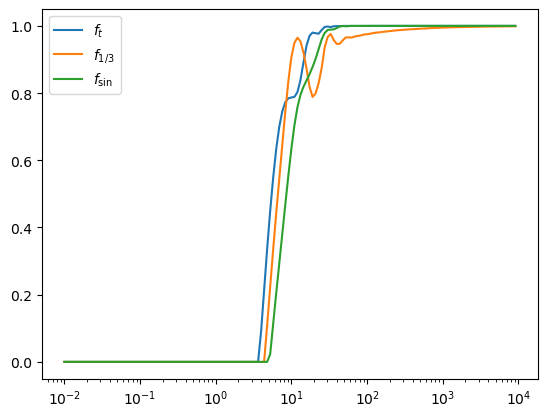

In [8]:
plt.plot(tau_list, Ergs_Ad[0], label = r'$f_t$')
plt.plot(tau_list, Ergs_Ad[1], label= r'$f_{1/3}$')
plt.plot(tau_list, Ergs_Ad[2], label= r'$f_{\sin}$')
plt.xscale('log')
plt.legend()
plt.show()

---
---
# TQD evolution
---
---

---
### Eigenvectors using SymPy
---

In [7]:
I,x,y,z = sp.eye(2),msigma(1),msigma(2),msigma(3)
hbar, Omg = sp.symbols(r'hbar, \Omega', real=True)
t = sp.symbols(r't', real=True, positive=True)
f = sp.Function('f')(t)
g = sp.Function('g')(t)
lmb = sp.symbols(r'\lambda')

### Linear

In [8]:
f, g = t, t

In [9]:
sHi = (ts(x,x,I)+ts(y,y,I))
sHm = (ts(I,x,x)+ts(I,y,y))
sHf = (ts(z,I,z) + ts(I,z,z))

sHad = (1-f)*sHi + f*(1-f)*sHm + g*sHf
sHad

Matrix([
[2*t,           0,           0,       0,       0,           0,           0,   0],
[  0,        -2*t, 2*t*(1 - t),       0,       0,           0,           0,   0],
[  0, 2*t*(1 - t),           0,       0, 2 - 2*t,           0,           0,   0],
[  0,           0,           0,       0,       0,     2 - 2*t,           0,   0],
[  0,           0,     2 - 2*t,       0,       0,           0,           0,   0],
[  0,           0,           0, 2 - 2*t,       0,           0, 2*t*(1 - t),   0],
[  0,           0,           0,       0,       0, 2*t*(1 - t),        -2*t,   0],
[  0,           0,           0,       0,       0,           0,           0, 2*t]])

In [10]:
m = sHad.eigenvects(chop=True)

In [11]:
e = [m[i//2][0] for i in range(len(m)*2)]
ev_ = [[tup[2][0], tup[2][1]] for tup in m]
ev = [val for sublist in ev_ for val in sublist]
evN = [vec/sp.sqrt((Dagger(vec)*vec)[0]) for vec in ev] 

---
---
#### Eigenvectors as functions of eigenvalues

In [ ]:
r0 = sp.Function(r'r_0', real=True)(t)
r1 = sp.Function(r'r_1', real=True)(t)
r2 = sp.Function(r'r_2', real=True)(t)
r3 = sp.Function(r'r_3', real=True)(t)
r_list = [r0,r0,r1,r1,r2,r2,r3,r3]

In [17]:
r_symbols = sp.symbols("r0:%s" % len(e))

In [18]:
r_vec = [] # ------------------ Eigenvectors function-------------------------
for vec, val, s in zip(ev, e, r_list):
    r_vec.append(
        vec.applyfunc(lambda t: t.subs(val, s))
    )

---
---

#### Test Eigenvectors ortonormality 
---

/home/lfcmoraes/anaconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


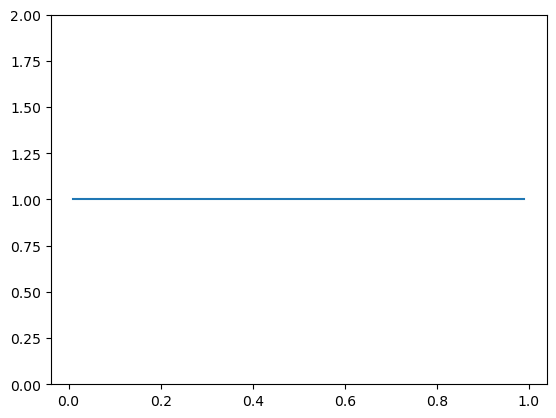

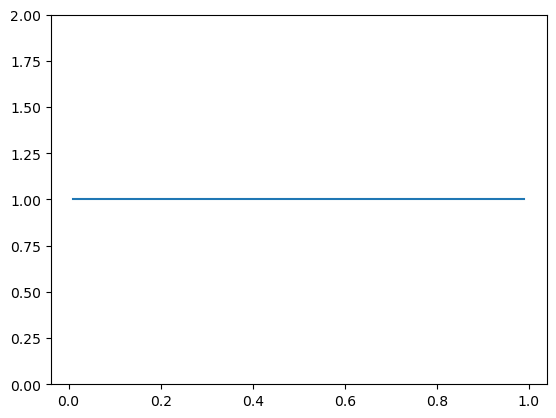

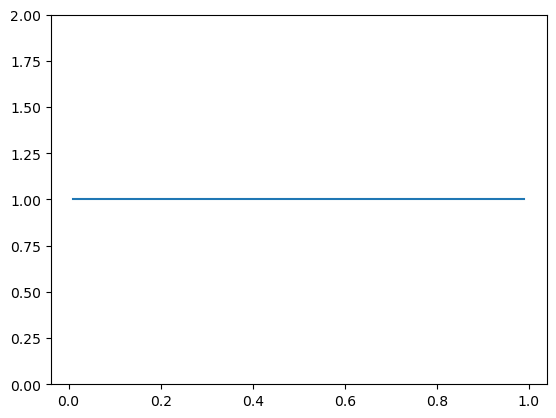

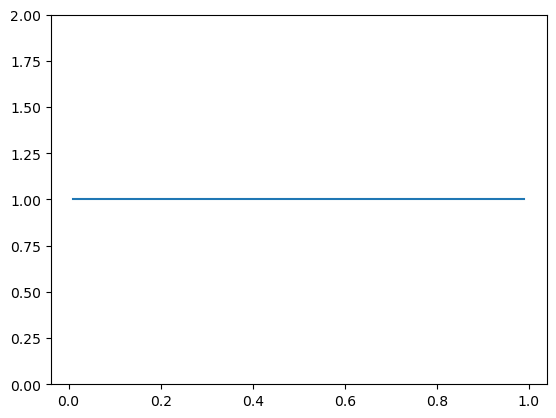

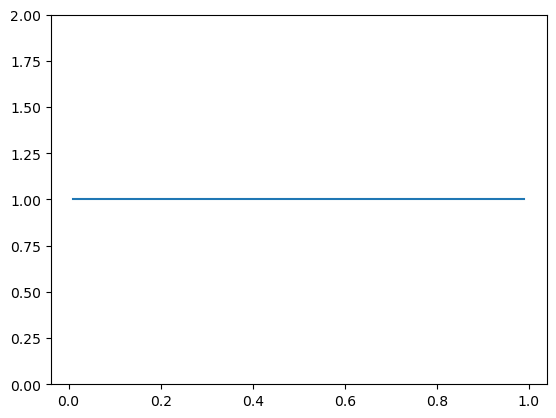

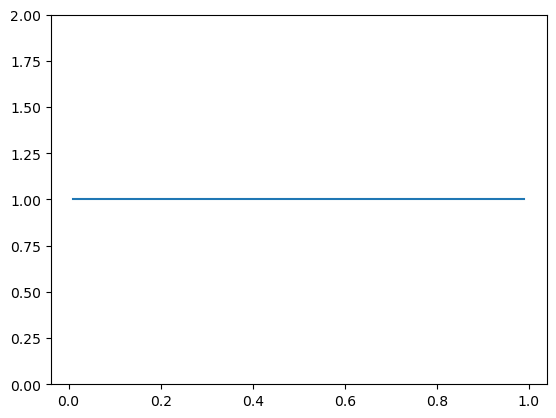

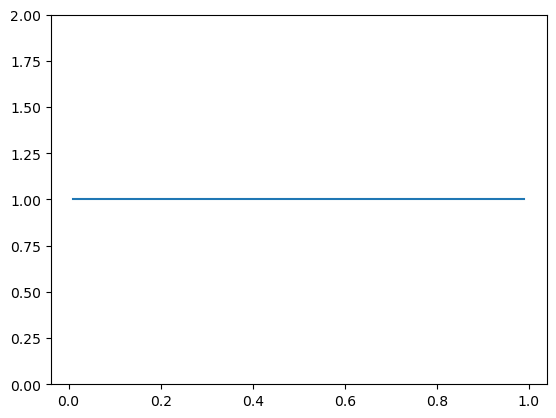

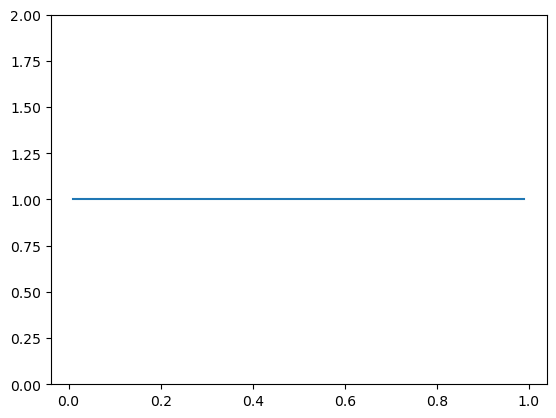

In [ ]:
for i in evN:
    x = (Dagger(i)*i)[0].evalf()
    lmbd_t = sp.lambdify(t, x, modules=['mpmath'])

    x_vals = np.linspace(0.01, .99, 1000, dtype=complex)

    y_vals = []
    for _x in x_vals:
        y_vals.append(complex(lmbd_t(_x)))
    plt.plot(x_vals,y_vals)
    # plt.title(i)
    plt.ylim(0,2)
    
    plt.show()


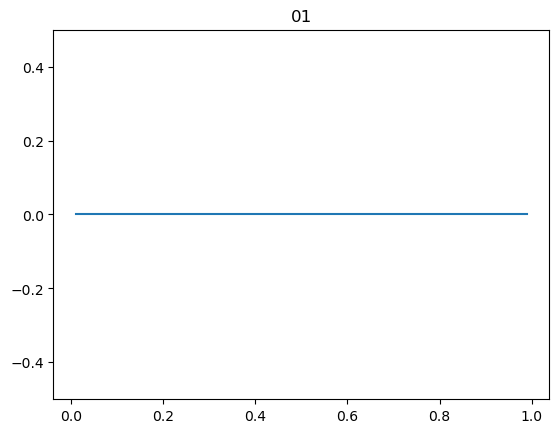

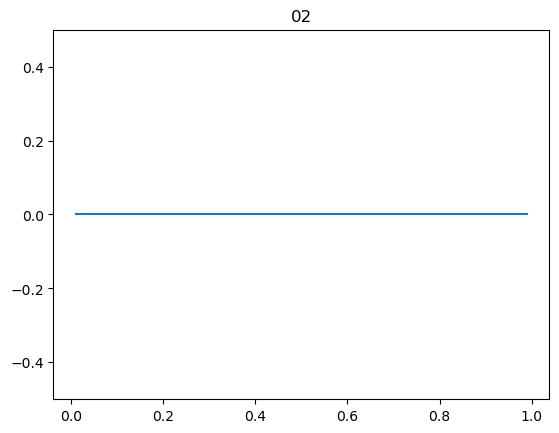

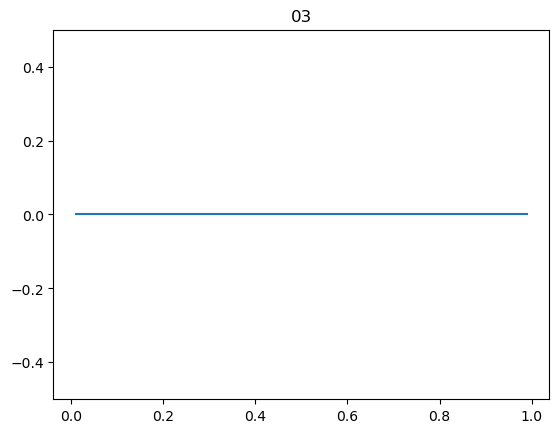

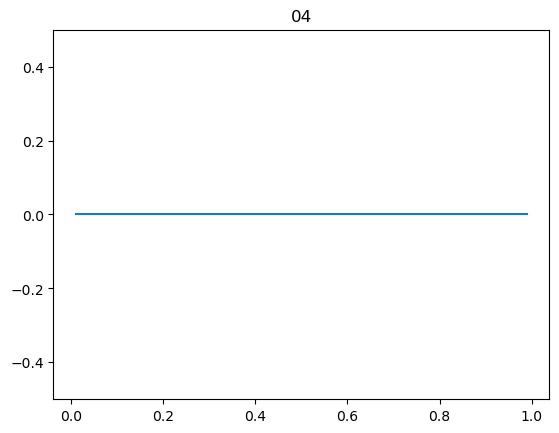

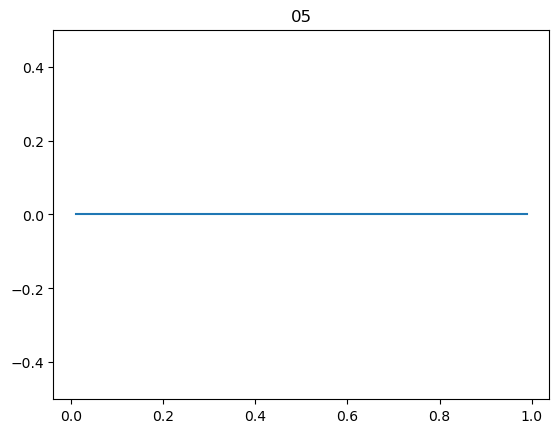

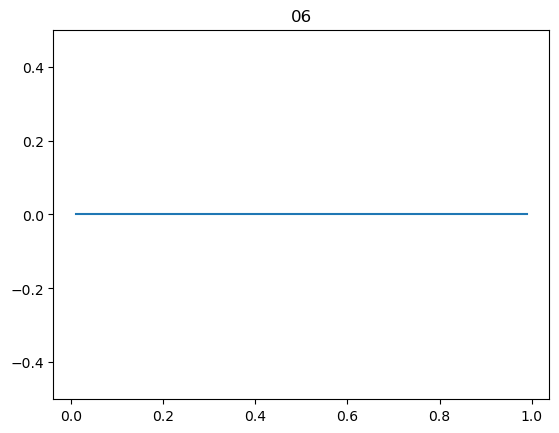

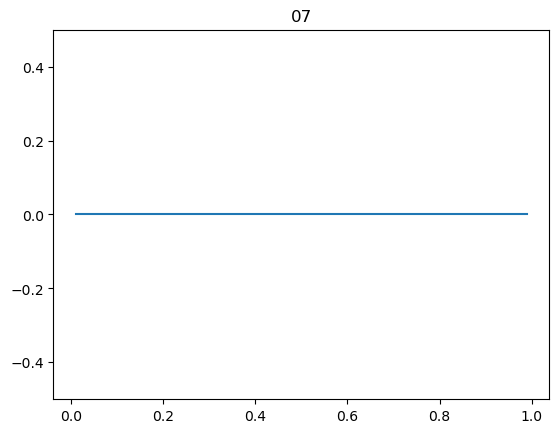

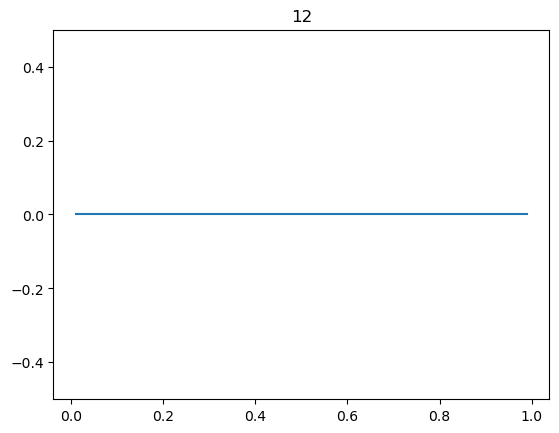

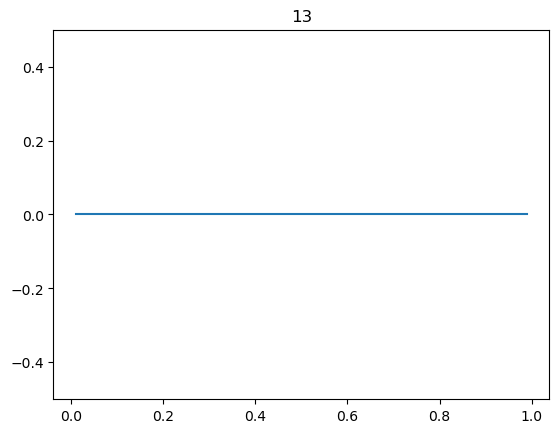

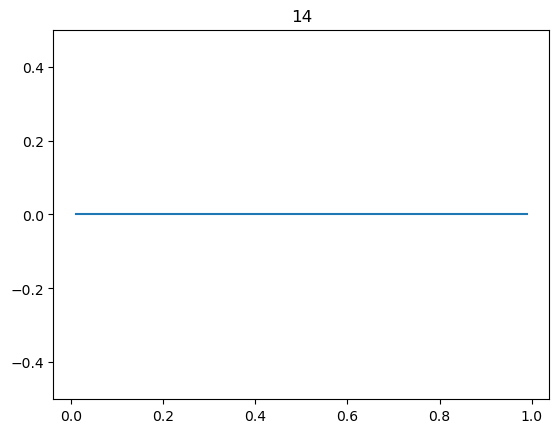

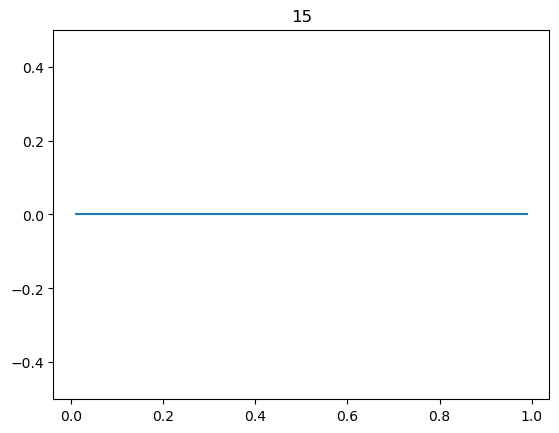

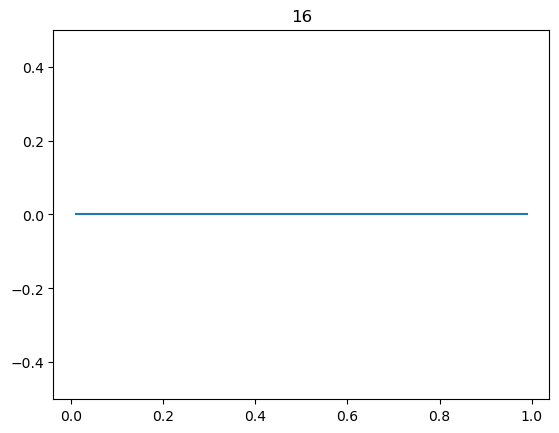

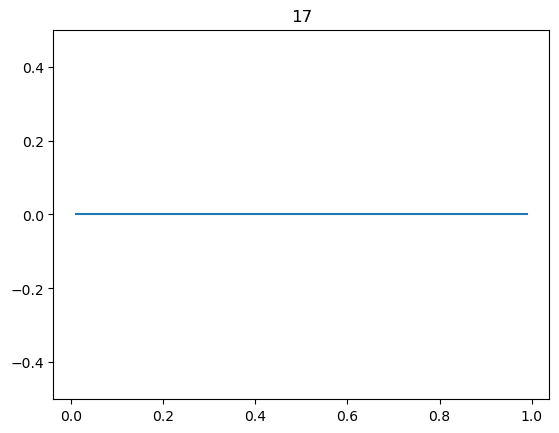

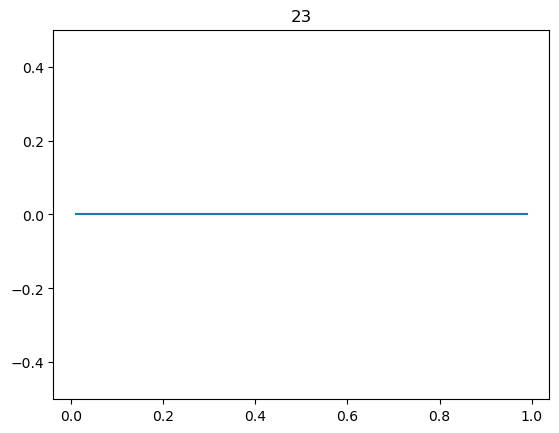

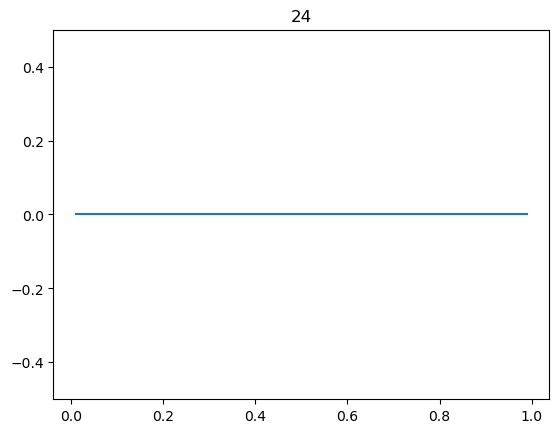

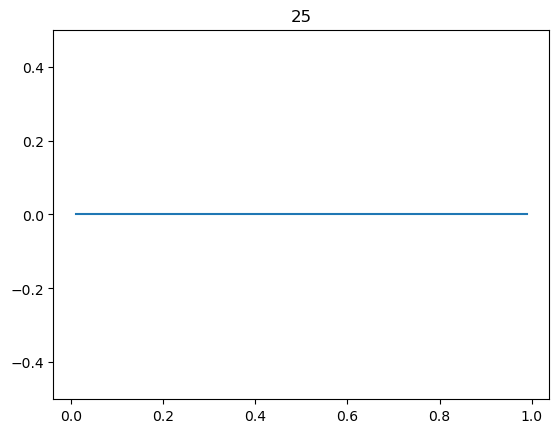

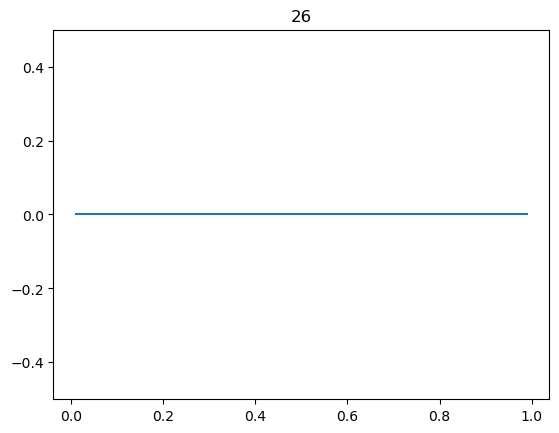

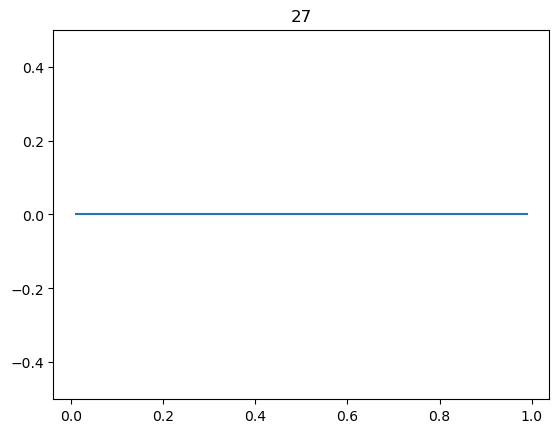

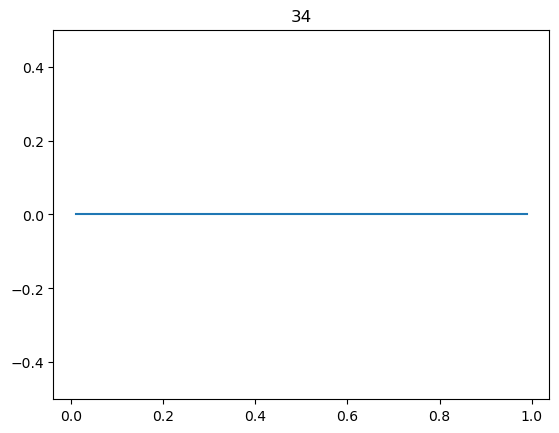

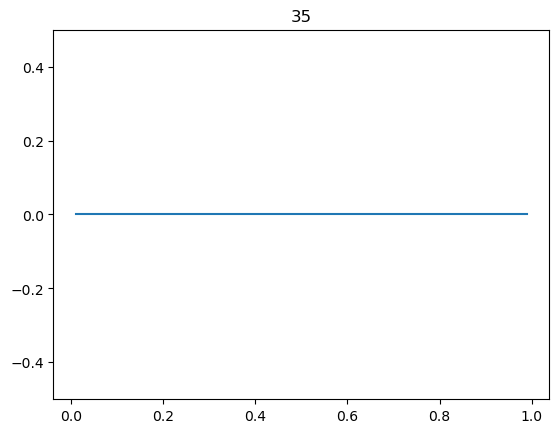

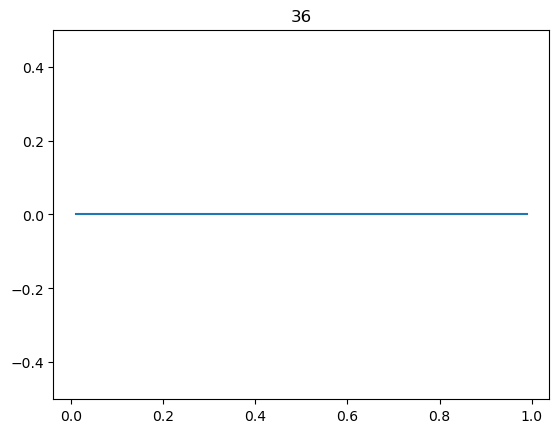

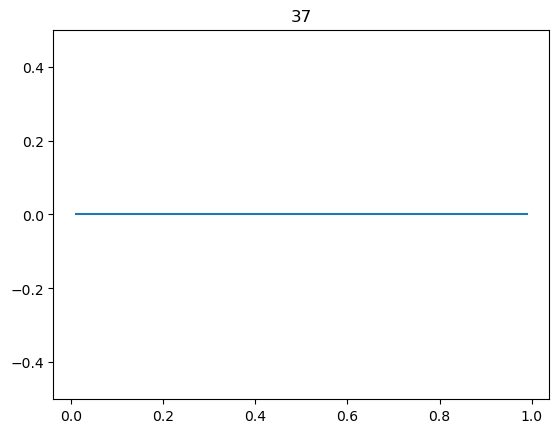

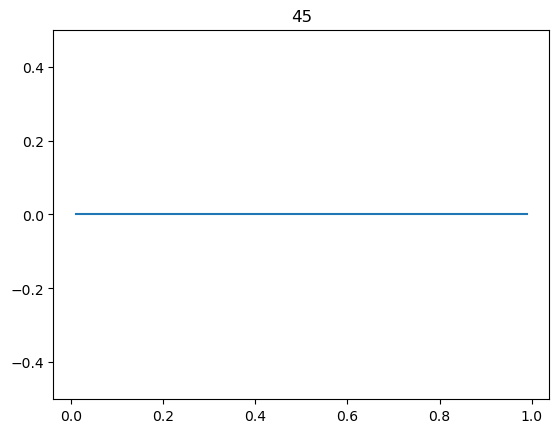

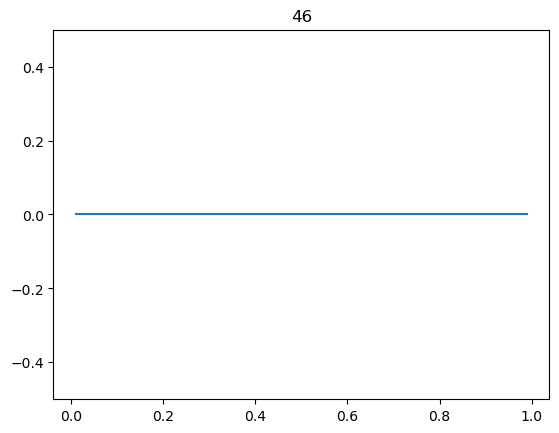

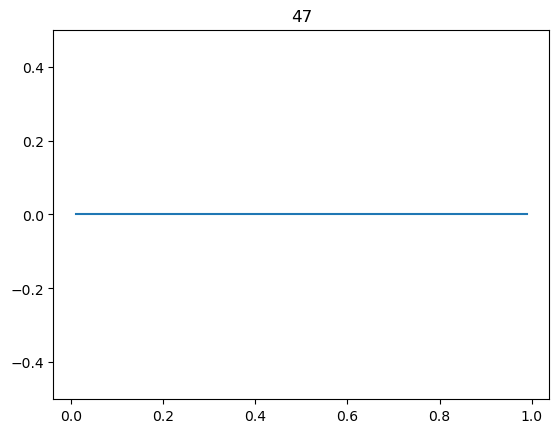

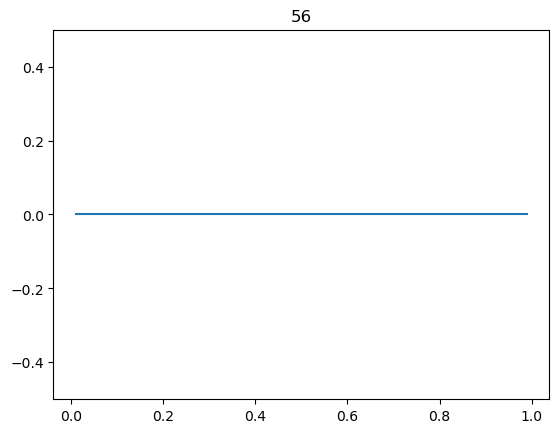

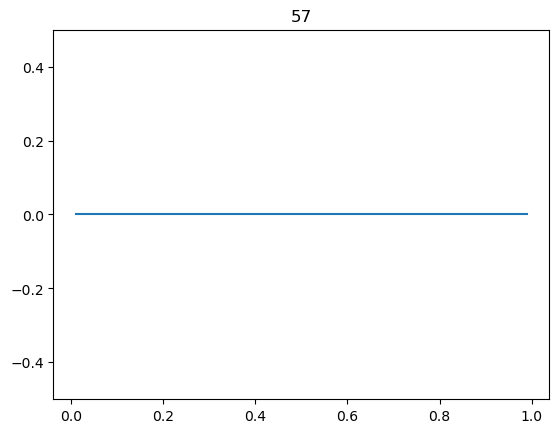

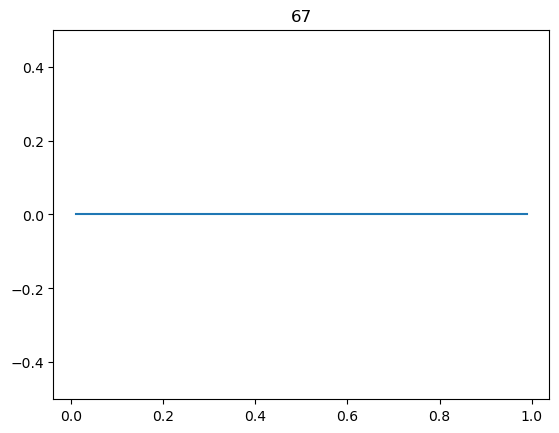

In [ ]:
for i in range(8):
    for j in range(8):
        if j>i:
            x = ((Dagger(evN[i])*evN[j])[0]).evalf()
            lmbd_t = sp.lambdify(t, x, modules=['mpmath'])

            x_vals = np.linspace(0.01, .99, 1000, dtype=complex)

            y_vals = []
            for _x in x_vals:
                y_vals.append(complex(lmbd_t(_x)))
            plt.plot(x_vals,y_vals)
            plt.title(str(i)+str(j))
            plt.ylim(-.5,.5)
            
            plt.show()

---

In [18]:
Hcd = sum([sp.diff(vec,t)*Dagger(vec) for vec in evN],sp.zeros(8,8))

In [19]:
nonZero_index_Hcd = (np.transpose(np.nonzero(Hcd))).tolist()
for i in nonZero_index_Hcd:
    if i[0] == i[1]:
        nonZero_index_Hcd.remove(i)
print(nonZero_index_Hcd)

[[1, 2], [1, 4], [2, 1], [2, 4], [3, 5], [3, 6], [4, 1], [4, 2], [5, 3], [5, 6], [6, 3], [6, 5]]


---
### HCD components to a array

In [15]:
Hcd_dic = { f"H{lst[0]}{lst[1]}": [] for lst in nonZero_index_Hcd}
for i, j in zip(nonZero_index_Hcd, Hcd_dic):
    print(i[0],i[1],j)
    x = Hcd[int(i[0]),int(i[1])].evalf()
    
    lam_x = sp.lambdify(t, x, modules=['mpmath'])

    x_vals = np.linspace(0.001, .99, 1000, dtype=complex)

    y_vals = []
    for _x in x_vals:
        y_vals.append(complex(lam_x(_x)))
    
    
    Hcd_dic[j].append(np.round(y_vals, decimals=5))

1 2 H12
1 4 H14
2 1 H21
2 4 H24
3 5 H35
3 6 H36
4 1 H41
4 2 H42
5 3 H53
5 6 H56
6 3 H63
6 5 H65


---
### Saving HCD components
---

In [16]:
path = r'data/HCD_AD/' 
if not os.path.exists(path):
    os.makedirs(path)

for H in Hcd_dic:
    with open(path + H, 'wb') as fp:
        pickle.dump(Hcd_dic[H], fp) 

---
### Reading HCD components
---

In [24]:
Hcd_dic = { f"H{lst[0]}{lst[1]}": [] for lst in nonZero_index_Hcd}
for H in Hcd_dic:
    with open (path+ H, 'rb') as fp:
        Hcd_dic[H] = pickle.load(fp)

H12 H65
H14 H63
H21 H56
H24 H53
H35 H42
H36 H41


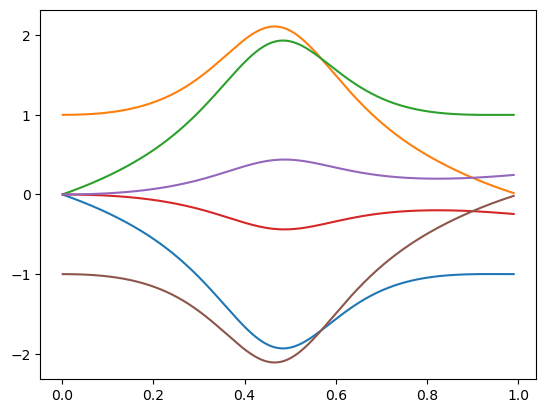

In [36]:
Hcd_nonZeroPair = []
for i in Hcd_dic:
    for j in Hcd_dic:
        if i != j:                
            if (np.round(np.subtract(Hcd_dic[i][0],Hcd_dic[j][0])) == 0.).all():
                if (i[1]<j[1]):
                            
                    print(i,j)                
                    x_vals = np.linspace(0.001, .99, 1000, dtype=complex)
                    y_vals_1 = Hcd_dic[i][0]
                    y_vals_2 = Hcd_dic[j][0]
                    # if np.any(y_vals_1):

                    plt.plot(np.real(x_vals), np.real(y_vals_1))
                    # print(i,j) 

                    Hcd_nonZeroPair.append([i,j])
                    # plt.plot(np.real(x_vals), np.real(y_vals_2))
plt.show()

---
### Interpolating HCD components
--- 

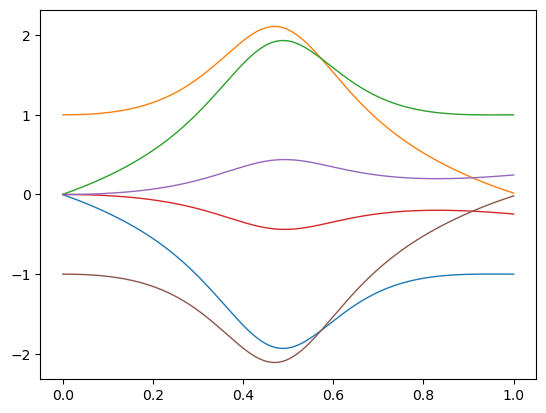

In [37]:
t_list = np.linspace(0,1,10000)
S = []
for i in Hcd_nonZeroPair:
    S.append(
        Cubic_Spline(t_list[0], t_list[-1], np.real(Hcd_dic[i[0]][0]))
        )
for s in S:
    plt.plot(t_list, s(t_list), lw=1)
plt.show()

---
### Solving the dynamics 
---

In [38]:
ergCD = []
F = []
for tau in tau_list:
    # print(tau_list.index(tau))
    # tau = tau_list[105]
    
    # HSD = [[tau*qHi,Hi_coef_lin],[tau*qHm,Hm_coef_lin],[tau*qHf,Hf_coef_lin]]     # ------ Had + Hcd ---- in the dynamics
    HSD = []                                                                        # ------ Hcd --- in the dynamics
    for i, s in zip(Hcd_nonZeroPair, S):
        # print('H',i[0][1],i[0][2],'H',i[1][1],i[1][2])
        H = np.zeros((8,8))
        H[int(i[0][1]),int(i[0][2])] +=1
        H[int(i[1][1]),int(i[1][2])] +=1
        HSD.append([1j*Qobj(H,dims = [[2, 2, 2], [2, 2, 2]]),s])
    
    
    result = mesolve(HSD,rho0, s_list)#, options= options)
    rho_t = result.states
# ------- Fidelity-----------------------------------
    F.append(
        (rho_t[-1]*rhof).tr()                           
    )
# #----spectral decomposition of H0------------------------------------
    ϵ, ϵ_v = qz.eigenstates(sort='low')
# #----spectral decomposition of rho(t)----------------------------------
    rhored = rho_t[-1].ptrace(2)
    r, r_v = rhored.eigenstates(sort='high')
# #----calculating ergotropy-------------------------------------------
    vr_ve = np.array([[((r_v[0].dag()*ϵ_v[0]).norm())**2, ((r_v[1].dag()*ϵ_v[0]).norm())**2],
                    [((r_v[0].dag()*ϵ_v[1]).norm())**2, ((r_v[1].dag()*ϵ_v[1]).norm())**2]])
    ergCD.append(
        np.real(
        np.sum(np.outer(r,ϵ)*(vr_ve - np.identity(2))/2)
                )
        )

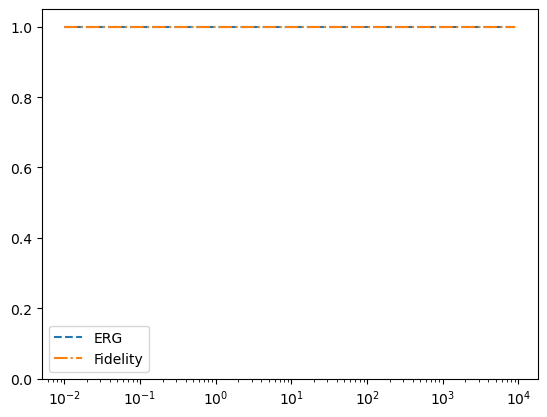

In [46]:
plt.plot(tau_list, ergCD,'--',label='ERG')
plt.plot(tau_list,F,'-.',label= "Fidelity")
plt.xscale('log')
plt.ylim(0,1.05)
plt.legend()
plt.show()

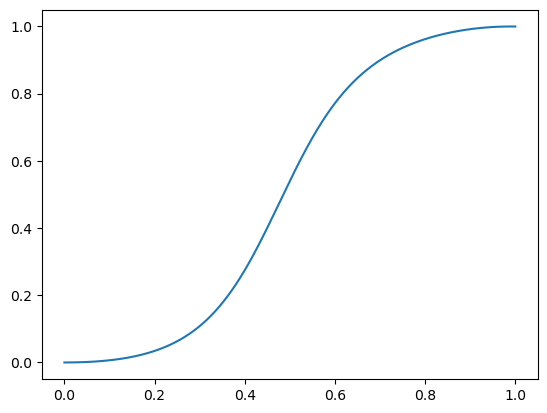

In [91]:
F = [(rho_t[s]*rhof).tr() for s in range(s_list.shape[0])]
plt.plot(s_list,F)
plt.show()

---
---
## $f(s) = \left(s\right)^{1/3}$ ------ $g(s) = s$

In [16]:
f, g = sp.cbrt(t), t

In [17]:
sHad_cbrt = (1-f)*sHi + f*(1-f)*sHm + g*sHf
sHad_cbrt

Matrix([
[2*t,                         0,                         0,              0,              0,                         0,                         0,   0],
[  0,                      -2*t, 2*t**(1/3)*(1 - t**(1/3)),              0,              0,                         0,                         0,   0],
[  0, 2*t**(1/3)*(1 - t**(1/3)),                         0,              0, 2 - 2*t**(1/3),                         0,                         0,   0],
[  0,                         0,                         0,              0,              0,            2 - 2*t**(1/3),                         0,   0],
[  0,                         0,            2 - 2*t**(1/3),              0,              0,                         0,                         0,   0],
[  0,                         0,                         0, 2 - 2*t**(1/3),              0,                         0, 2*t**(1/3)*(1 - t**(1/3)),   0],
[  0,                         0,                         0,              0,    

In [26]:
P = sp.factor(sp.simplify(sp.collect(sp.factor(sHad_cbrt.charpoly(lmb).as_expr()),(lmb))))
P.rewrite(2*t -lmb)

\lambda**8 - 8*\lambda**6*t**(4/3) - 16*\lambda**6*t**(2/3) + 16*\lambda**6*t**(1/3) - 8*\lambda**6*t**2 + 16*\lambda**6*t - 8*\lambda**6 + 16*\lambda**5*t**(7/3) + 16*\lambda**5*t**(5/3) - 32*\lambda**5*t**2 + 32*\lambda**4*t**(10/3) + 112*\lambda**4*t**(8/3) - 192*\lambda**4*t**(7/3) - 192*\lambda**4*t**(5/3) + 224*\lambda**4*t**(4/3) + 128*\lambda**4*t**(2/3) - 64*\lambda**4*t**(1/3) + 16*\lambda**4*t**4 - 64*\lambda**4*t**3 + 192*\lambda**4*t**2 - 192*\lambda**4*t + 16*\lambda**4 - 64*\lambda**3*t**(13/3) - 128*\lambda**3*t**(11/3) + 256*\lambda**3*t**(10/3) + 512*\lambda**3*t**(8/3) - 448*\lambda**3*t**(7/3) - 64*\lambda**3*t**(5/3) + 128*\lambda**3*t**4 - 448*\lambda**3*t**3 + 256*\lambda**3*t**2 - 64*\lambda**2*t**(14/3) + 256*\lambda**2*t**(11/3) - 832*\lambda**2*t**(10/3) - 896*\lambda**2*t**(8/3) + 512*\lambda**2*t**(7/3) + 128*\lambda**2*t**4 + 1024*\lambda**2*t**3 - 128*\lambda**2*t**2 - 1024*\lambda*t**(14/3) + 1536*\lambda*t**(13/3) + 256*\lambda*t**(11/3) + 256*\lambda*t

In [110]:
_m = list(sHad_cbrt.eigenvals())
m_cbrt = [_m[i//2] for i in range(len(_m)*2)]

---
#### Subs $r_i$

In [123]:
ev_cbrt = []
for vec, val, s in zip(r_vec, m_cbrt,r_list):
    ev_cbrt.append(
        vec.subs(s,val)
    )
evN_cbrt = [vec/sp.sqrt((Dagger(vec)*vec)[0]) for vec in ev_cbrt]

---
#### Check Ortonormality

/home/lfcmoraes/anaconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


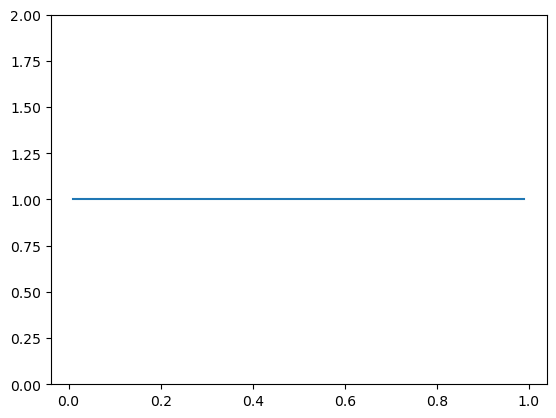

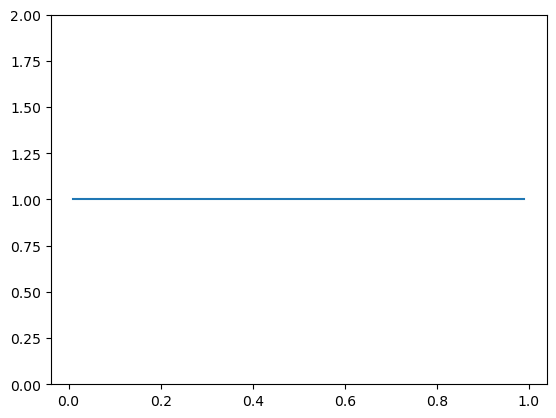

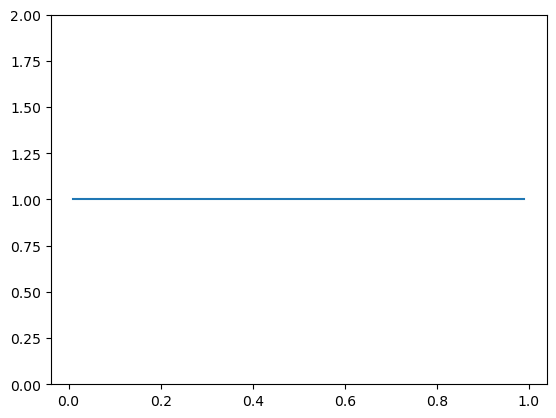

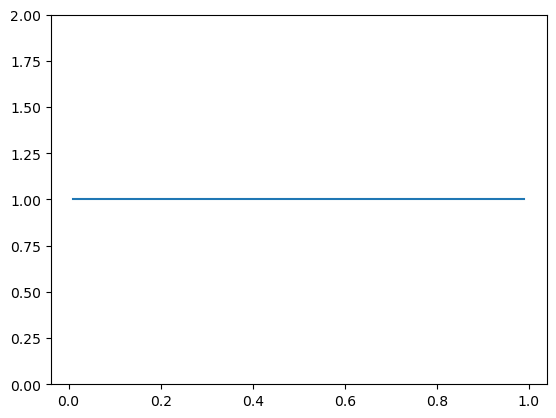

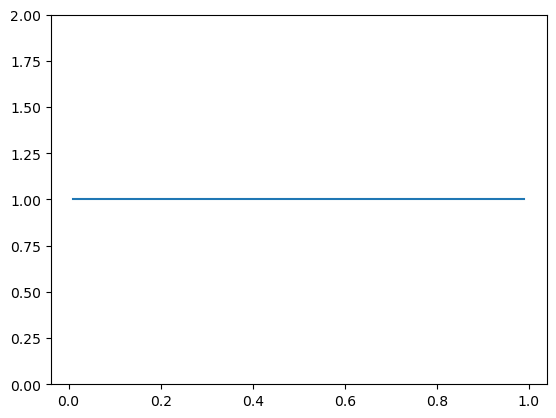

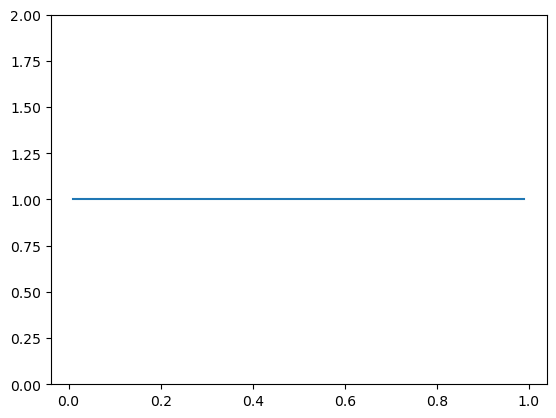

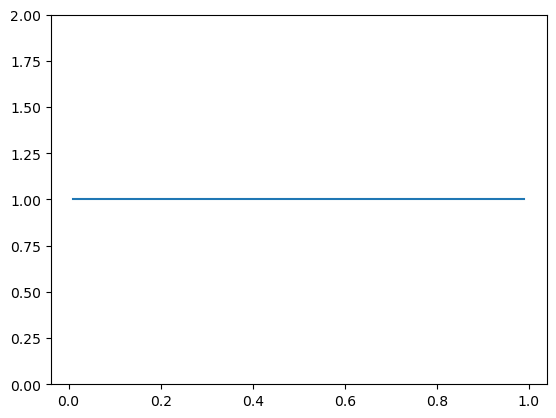

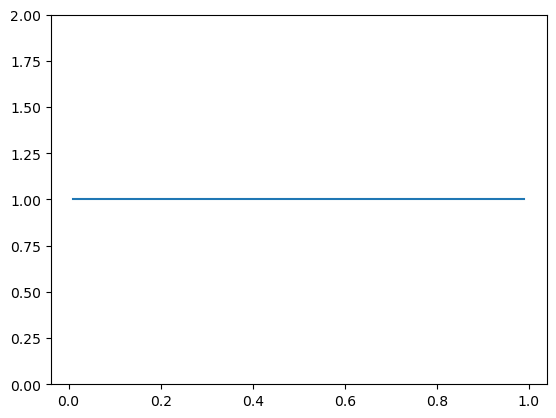

In [124]:
for i in evN_cbrt:
    x = (Dagger(i)*i)[0].evalf()
    lmbd_t = sp.lambdify(t, x, modules=['mpmath'])

    x_vals = np.linspace(0.01, .99, 1000, dtype=complex)

    y_vals = []
    for _x in x_vals:
        y_vals.append(complex(lmbd_t(_x)))
    plt.plot(x_vals,y_vals)
    # plt.title(i)
    plt.ylim(0,2)
    
    plt.show()


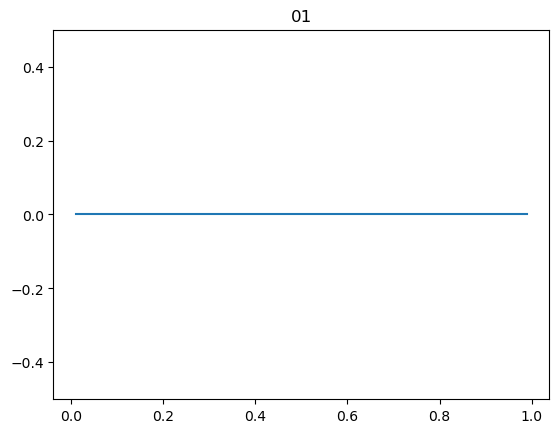

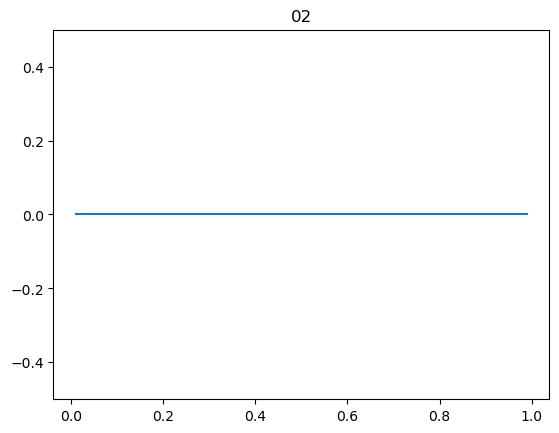

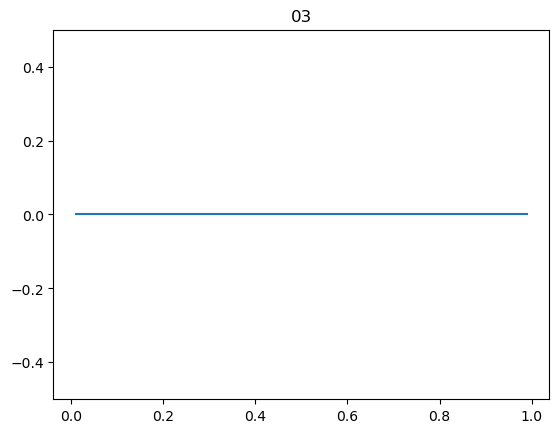

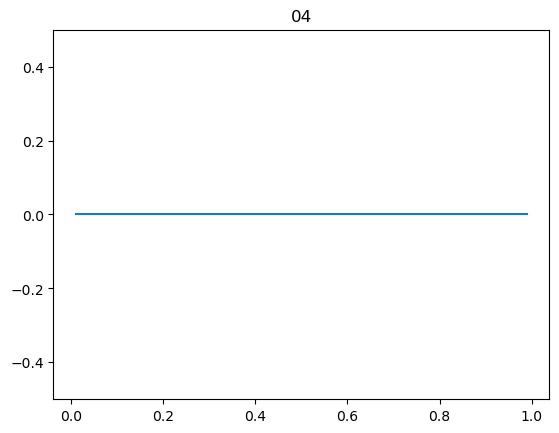

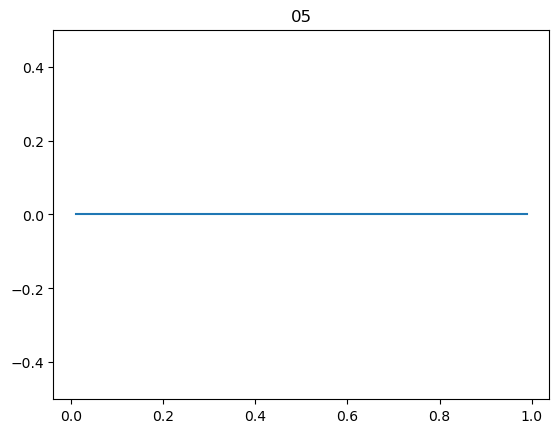

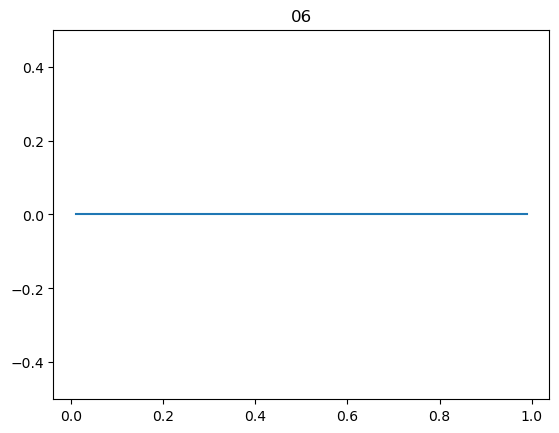

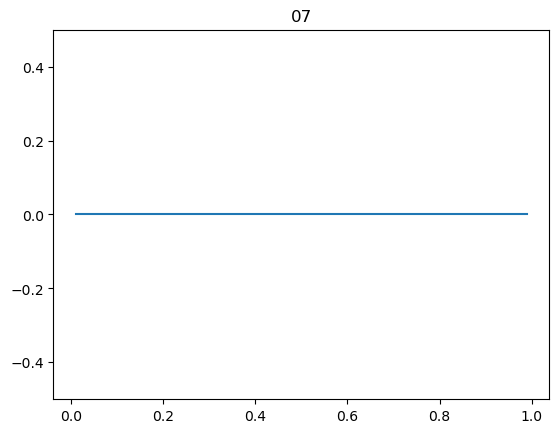

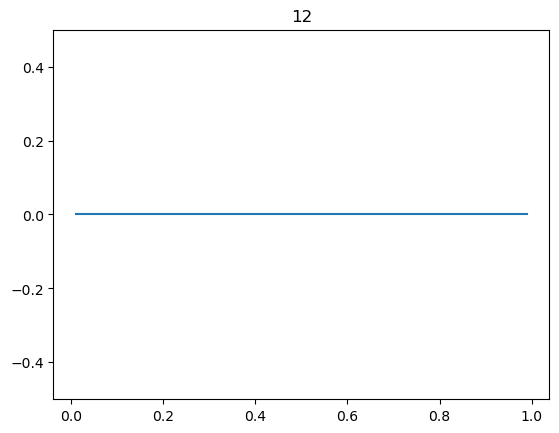

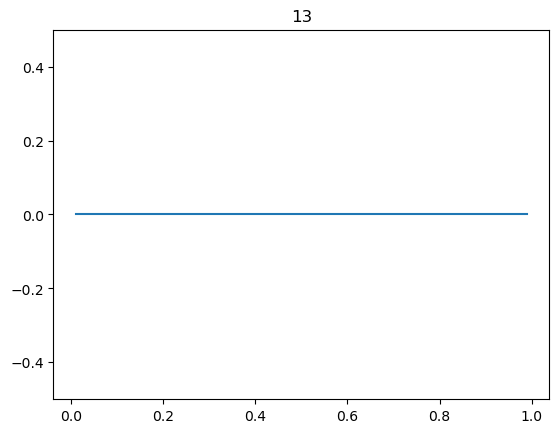

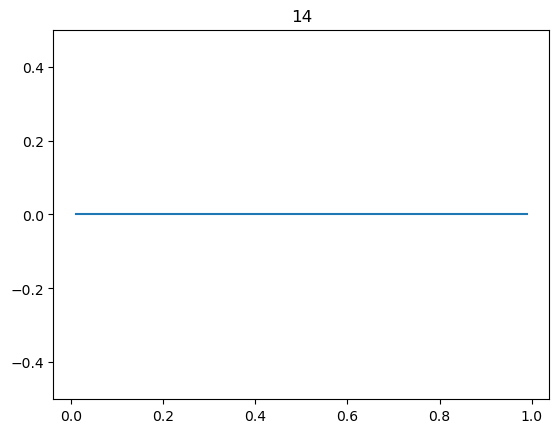

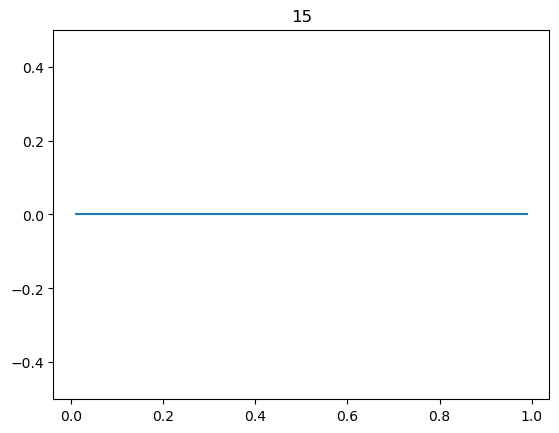

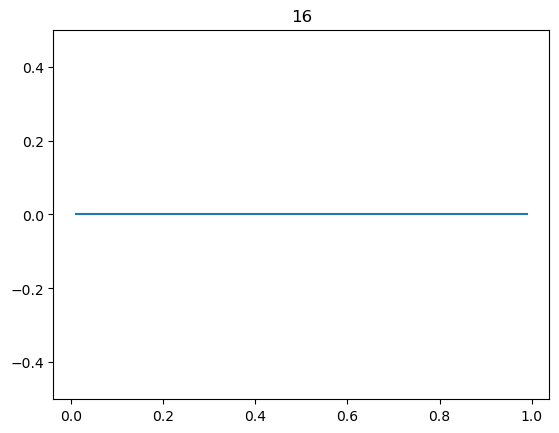

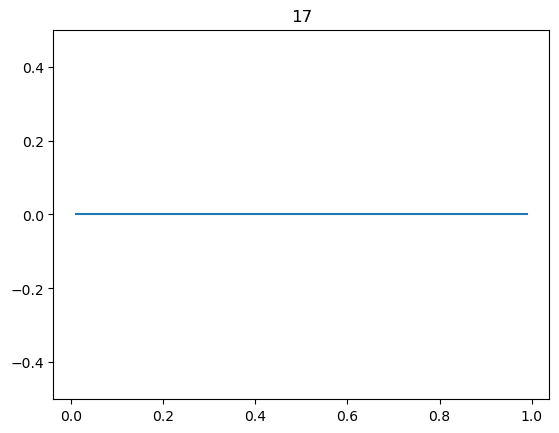

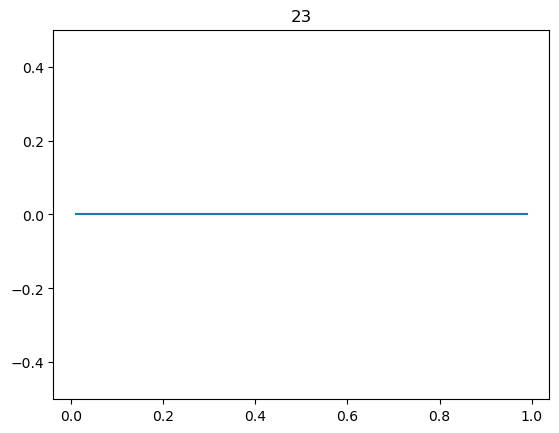

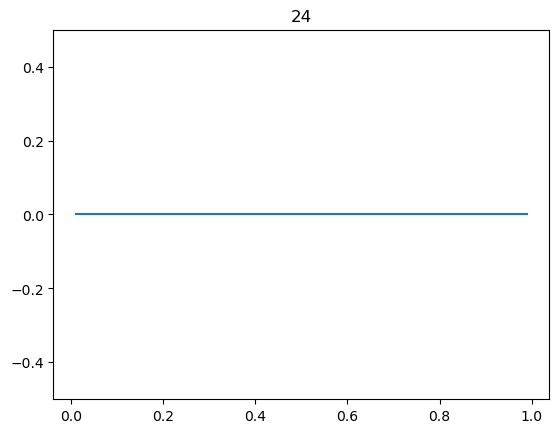

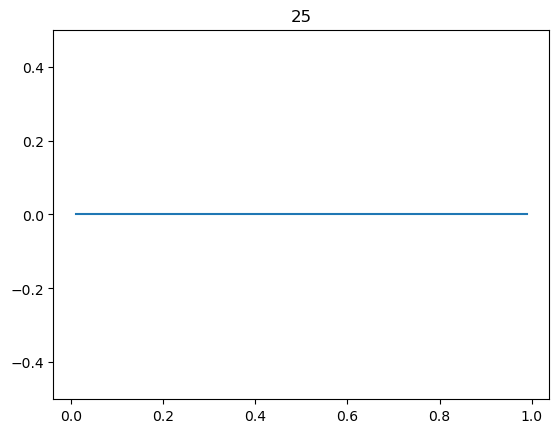

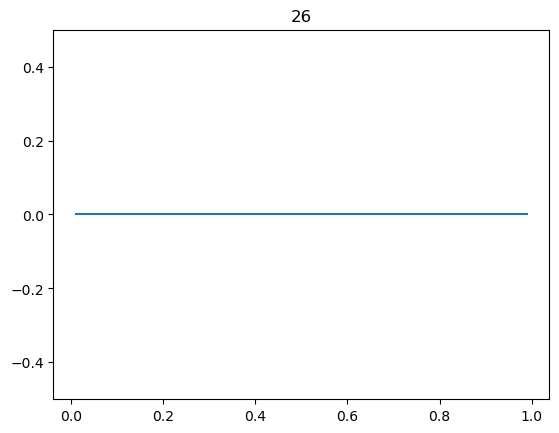

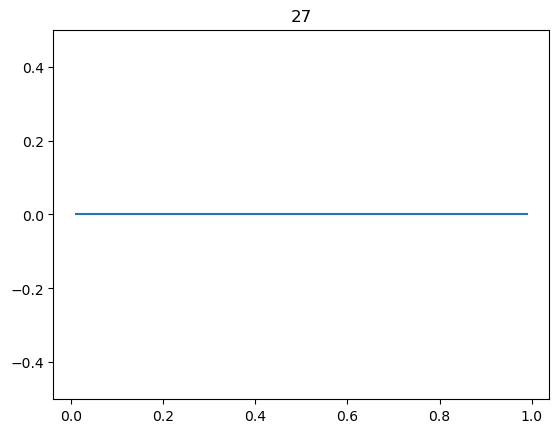

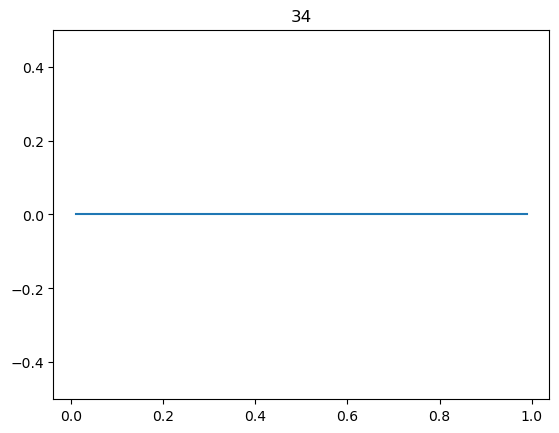

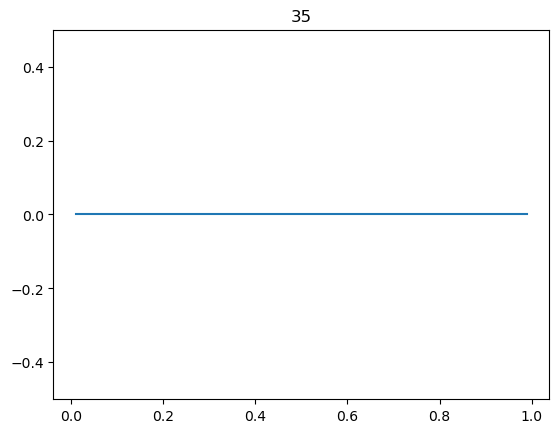

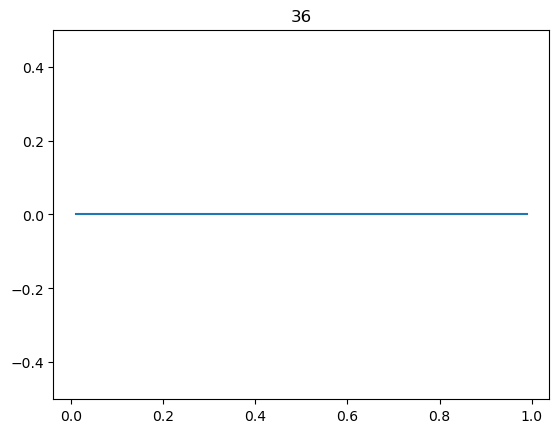

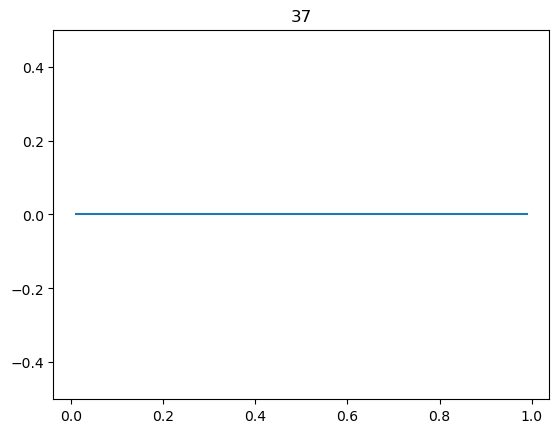

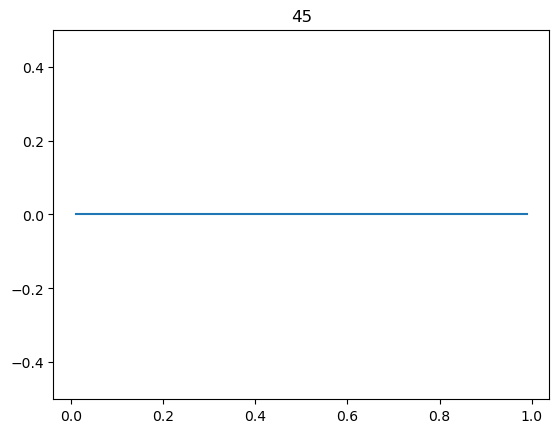

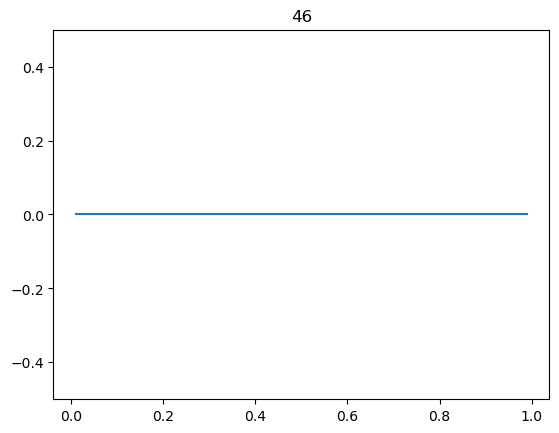

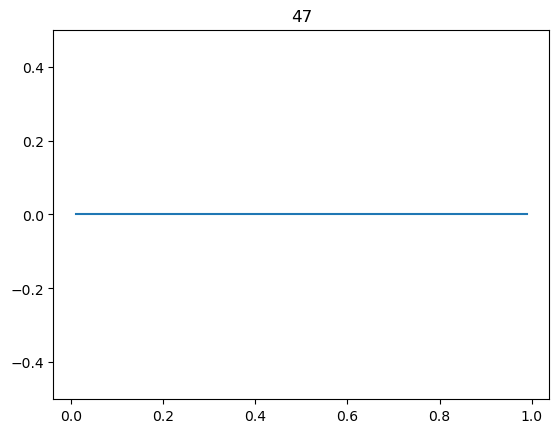

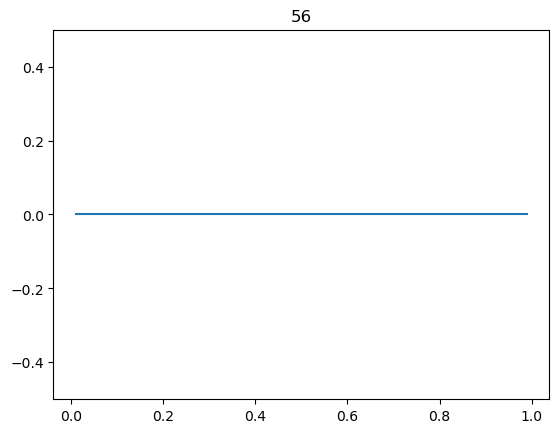

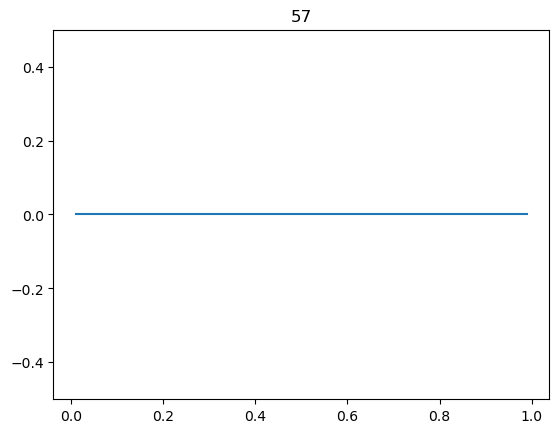

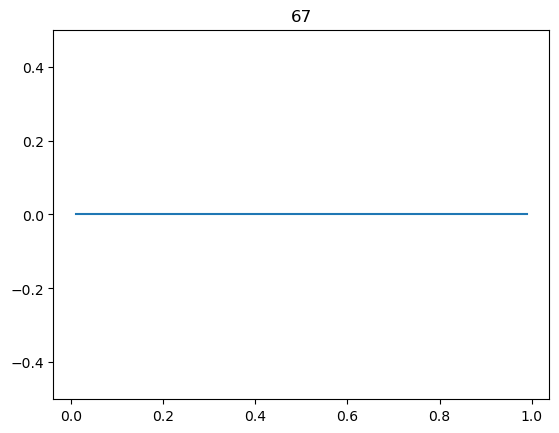

In [125]:
for i in range(8):
    for j in range(8):
        if j>i:
            x = ((Dagger(evN[i])*evN[j])[0]).evalf()
            lmbd_t = sp.lambdify(t, x, modules=['mpmath'])

            x_vals = np.linspace(0.01, .99, 1000, dtype=complex)

            y_vals = []
            for _x in x_vals:
                y_vals.append(complex(lmbd_t(_x)))
            plt.plot(x_vals,y_vals)
            plt.title(str(i)+str(j))
            plt.ylim(-.5,.5)
            
            plt.show()

---

In [126]:
Hcd = sum([sp.diff(vec,t)*Dagger(vec) for vec in evN_cbrt],sp.zeros(8,8))

In [128]:
nonZero_index_Hcd = (np.transpose(np.nonzero(Hcd))).tolist()
for i in nonZero_index_Hcd:
    if i[0] == i[1]:
        nonZero_index_Hcd.remove(i)
print(nonZero_index_Hcd)

[[1, 2], [1, 4], [2, 1], [2, 4], [3, 5], [3, 6], [4, 1], [4, 2], [5, 3], [5, 6], [6, 3], [6, 5]]


In [129]:
Hcd_dic = { f"H{lst[0]}{lst[1]}": [] for lst in nonZero_index_Hcd}
for i, j in zip(nonZero_index_Hcd, Hcd_dic):
    print(i[0],i[1],j)
    x = Hcd[int(i[0]),int(i[1])].evalf()
    
    lam_x = sp.lambdify(t, x, modules=['mpmath'])

    x_vals = np.linspace(0.01, .99, 1000, dtype=complex)

    y_vals = []
    for _x in x_vals:
        y_vals.append(complex(lam_x(_x)))
    
    
    Hcd_dic[j].append(np.round(y_vals, decimals=5))

1 2 H12
1 4 H14
2 1 H21
2 4 H24
3 5 H35
3 6 H36
4 1 H41
4 2 H42
5 3 H53
5 6 H56
6 3 H63
6 5 H65


---
#### Saving Hcd components

In [130]:
for H in Hcd_dic:
    with open('data/Hcd_cbrt/'+ H, 'wb') as fp:
        pickle.dump(Hcd_dic[H], fp) 

---

### Reading components

In [131]:
Hcd_dic = { f"H{lst[0]}{lst[1]}": [] for lst in nonZero_index_Hcd}
for H in Hcd_dic:
    with open ('data/Hcd_cbrt/'+ H, 'rb') as fp:
        Hcd_dic[H] = pickle.load(fp)

---

H12 H21
H12 H24
H12 H35
H12 H36
H12 H41
H12 H42
H12 H53
H12 H56
H12 H63
H12 H65
H14 H21
H14 H24
H14 H35
H14 H36
H14 H41
H14 H42
H14 H53
H14 H56
H14 H63
H14 H65
H21 H35
H21 H36
H21 H41
H21 H42
H21 H53
H21 H56
H21 H63
H21 H65
H24 H35
H24 H36
H24 H41
H24 H42
H24 H53
H24 H56
H24 H63
H24 H65
H35 H41
H35 H42
H35 H53
H35 H56
H35 H63
H35 H65
H36 H41
H36 H42
H36 H53
H36 H56
H36 H63
H36 H65
H41 H53
H41 H56
H41 H63
H41 H65
H42 H53
H42 H56
H42 H63
H42 H65
H53 H63
H53 H65
H56 H63
H56 H65


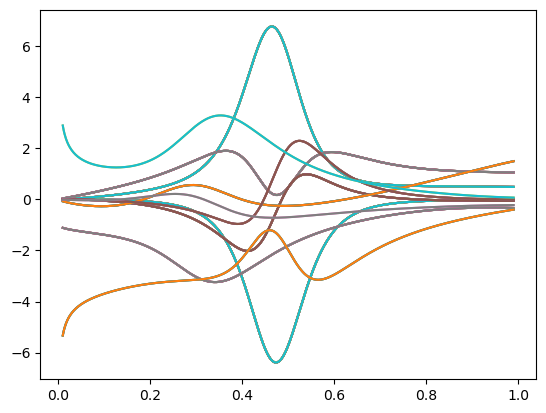

In [139]:
Hcd_nonZeroPair = []
for i in Hcd_dic:
    for j in Hcd_dic:
        if i != j:
            if (i[1]<j[1]):  
                # if (np.subtract(Hcd_dic[i][0],Hcd_dic[j][0]) == 0.).all():
                # if len(np.unique(np.subtract(Hcd_dic[i][0],Hcd_dic[j][0])))<=2:                            
                                        
                x_vals = np.linspace(0.01, .99, 1000, dtype=complex)
                y_vals_1 = Hcd_dic[i][0]
                # y_vals_2 = Hcd_dic[j][0]
                if np.any(y_vals_1):

                    plt.plot(np.real(x_vals), np.real(y_vals_1))
                    print(i,j) 

                    Hcd_nonZeroPair.append([i,j])
                # plt.plot(np.real(x_vals), np.real(y_vals_2))
plt.show()